In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

sns.set()

In [5]:
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50V2

In [6]:
img_format = ['jpeg', 'jpg', 'png']
data_dir = "Emotion/train"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_type = imghdr.what(file_path)
            if file_type not in img_format :
                print(f'File type not allowed {file_type}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)
        except Exception as e:
            print(f'Issue with File {file_path}, Error {e}')
            os.remove(file_path)

File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
File type not allowed None
F

In [7]:
# Counting the number of images

def count(directory, set_name):
    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))
            
    df = pd.DataFrame(counts, index = [set_name])
    return df

train = "Emotion/train"
test = "Emotion/test"

# Counting through Train Folder
train_counts = count(train, "Train")
print(train_counts)

# Counting through Test Folder
test_counts = count(test, "Test")
print(test_counts)

        sad  angry  fear  disgust  neutral  surprise  happy
Train  4830   3995  4096      436     4965      3171   7215
       sad  angry  fear  disgust  neutral  surprise  happy
Test  2494   1916  2048      222     2466      1662   3548


<Axes: >

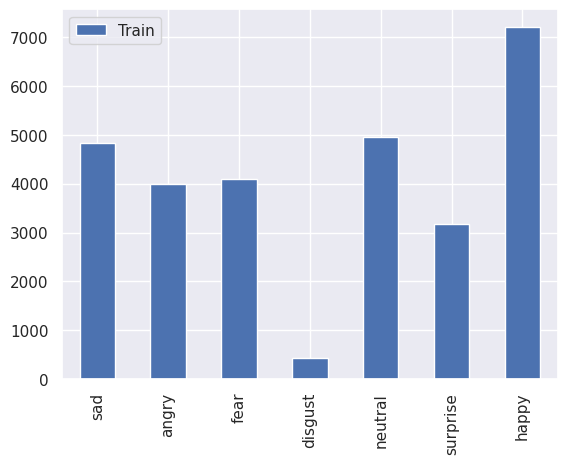

In [8]:
train_counts.transpose().plot(kind = 'bar')

<Axes: >

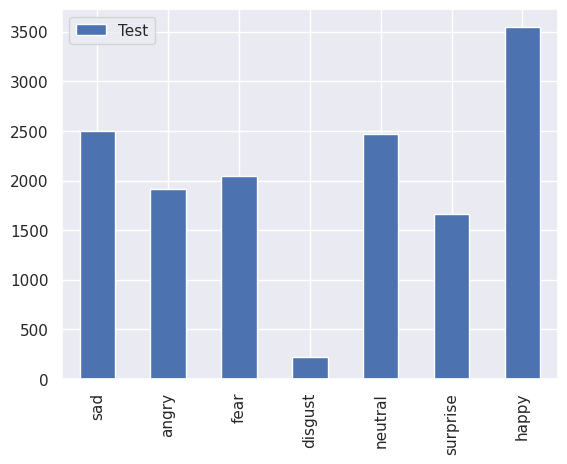

In [9]:
test_counts.transpose().plot(kind = 'bar')

In [10]:
train_dir = train
test_dir = test

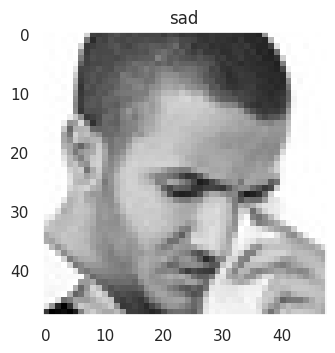

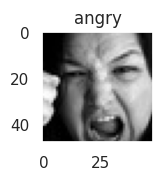

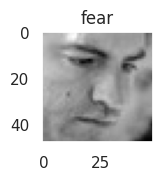

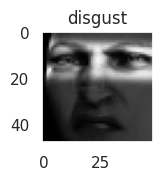

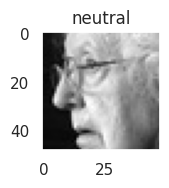

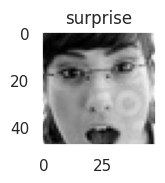

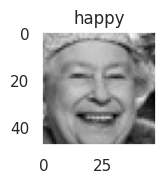

In [11]:
# Plotting one image from each type

emotions = os.listdir(train_dir)
plt.figure(figsize = (15, 10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[4])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap = 'gray')
    plt.title(emotion)
    plt.grid(False)
    plt.tight_layout()
    plt.show()   

In [12]:
classes = []
for i in os.listdir(test_dir):
    classes.append(i)
    
print(classes)

['sad', 'angry', 'fear', 'disgust', 'neutral', 'surprise', 'happy']


In [13]:
# Plotting random picture from directories

def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)

    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

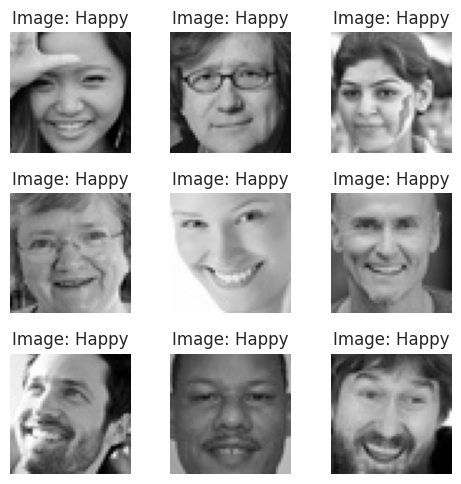

In [41]:
happy_filepath = "Emotion/train/happy"
sad_filepath = "Emotion/train/sad"
nuetral_filepath = "Emotion/train/neutral"

plot_images_from_directory(happy_filepath, 'Happy')

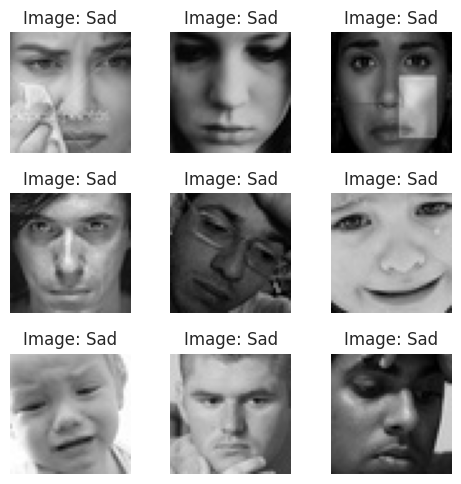

In [42]:
plot_images_from_directory(sad_filepath, 'Sad')

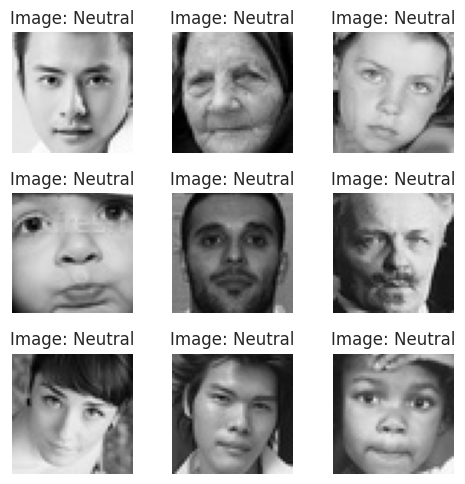

In [43]:
plot_images_from_directory(nuetral_filepath, 'Neutral')

In [44]:
import shutil

Balancing the Dataset

In [14]:
# Balancing the image dataset

base_dir = os.makedirs("Emotion_balanced", exist_ok = True)
base_dir = "Emotion_balanced"

In [15]:
train_dir = os.makedirs(os.path.join(base_dir, "Train"), exist_ok = True)
train_dir = "Emotion_balanced/Train"
test_dir = os.makedirs(os.path.join(base_dir, "Test"), exist_ok = True)
test_dir = "Emotion_balanced/Test"
for c in classes:
    train_class_dir = os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    test_class_dir = os.makedirs(os.path.join(test_dir, c), exist_ok = True)

In [16]:
def copy_img(source, destination , size = 436):
    img_files = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
    if len(img_files) < size:
        print(f'Not Enough Images in the souce folder. Found{len(img_files)} Requested{size}')
        size = len(img_files)
    for i in range(size):
        source_img = os.path.join(source, img_files[i])
        destination_img = os.path.join(destination, img_files[i])
        shutil.copy(source_img, destination_img)

In [ ]:
for c in classes:
    # Copying Train
    p = os.path.join(train, c)
    q = os.path.join(train_dir, c)
    copy_img(p, q)
    
    # Copying Test
    a = os.path.join(test, c)
    b = os.path.join(test_dir, c)
    copy_img(a, b, 111)

In [45]:
# Hyperparameters

BATCH_SIZE = 100
IMG_SHAPE = 48
EPOCHS = 100
NUM_CLASSES = 7

Augmentation

In [17]:
# Plot function

def PlotImage(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [18]:
# Augmenting Style of Image
img_gen = ImageDataGenerator(rescale = 1./255, 
                             rotation_range = 40, 
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             fill_mode = 'nearest',
                             validation_split = 0.2)

# Applying Augmentation
train_generator = img_gen.flow_from_directory(batch_size = BATCH_SIZE, directory = train_dir, shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE), class_mode = 'categorical', color_mode = 'grayscale', subset = 'training')
val_generator = img_gen.flow_from_directory(batch_size = BATCH_SIZE, directory = train_dir, shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE), class_mode = 'categorical', color_mode = 'grayscale', subset = 'validation')
test_generator = img_gen.flow_from_directory(batch_size = BATCH_SIZE, directory = test_dir, shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE), class_mode = 'categorical', color_mode = 'grayscale')

Found 22967 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


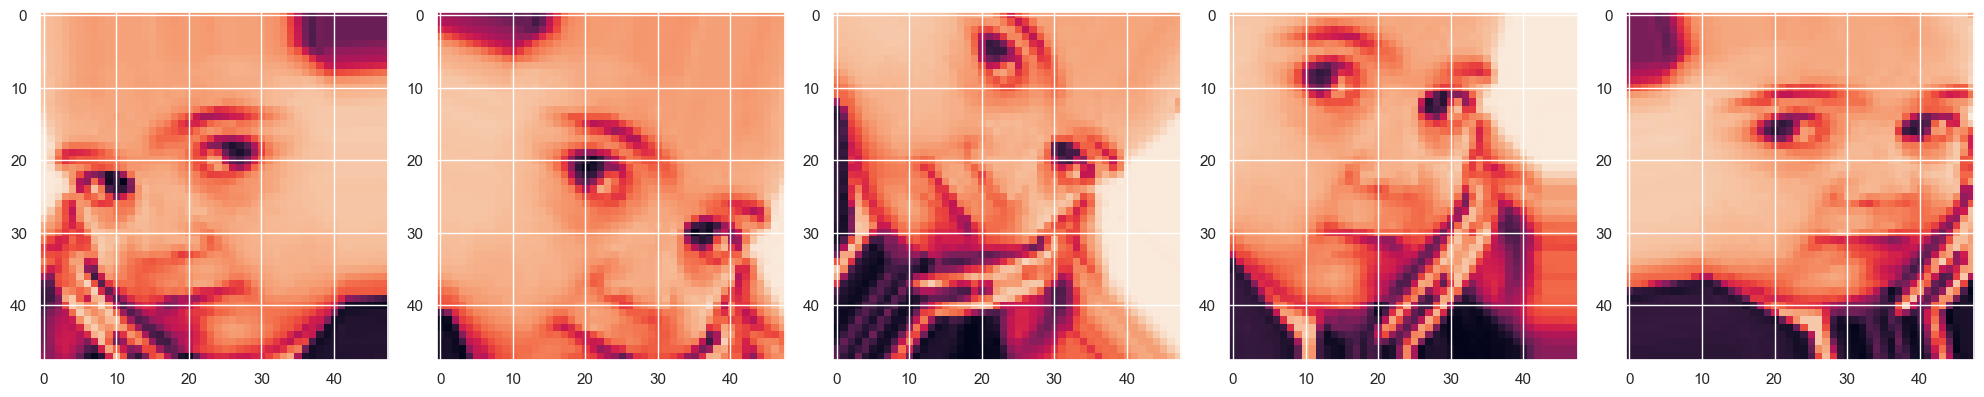

In [19]:
augmented_train_img = [train_generator[0][0][0] for i in range(5)]
PlotImage(augmented_train_img)

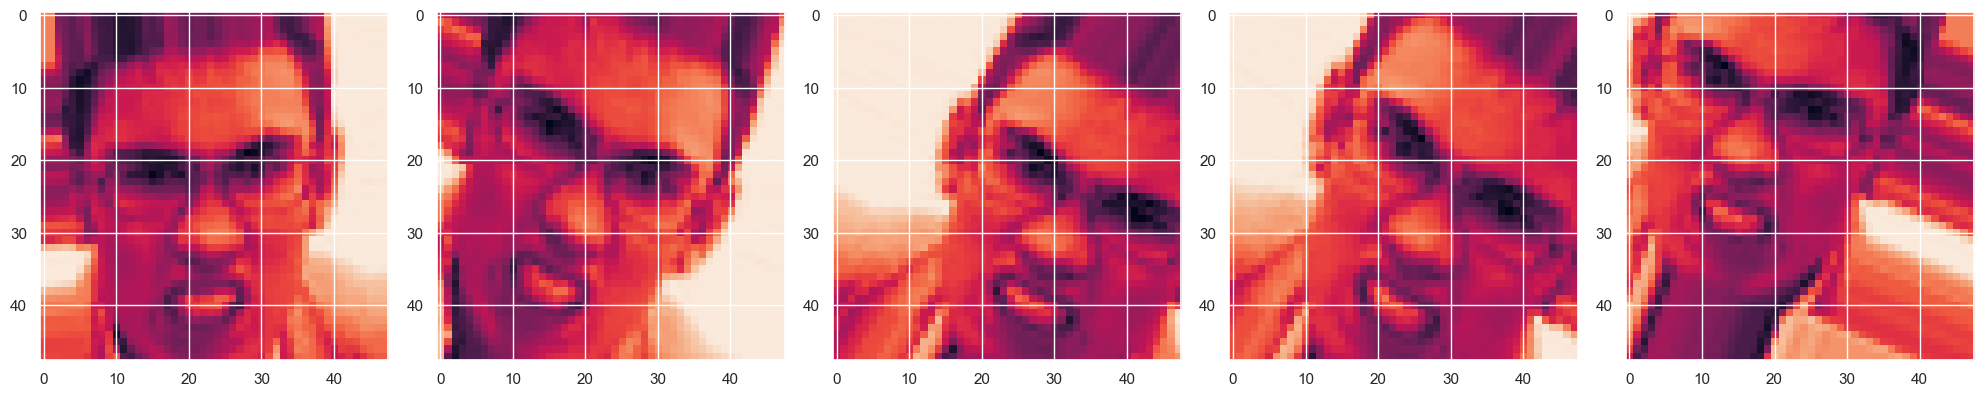

In [20]:
augmented_val_img = [val_generator[0][0][0] for i in range(5)]
PlotImage(augmented_val_img)

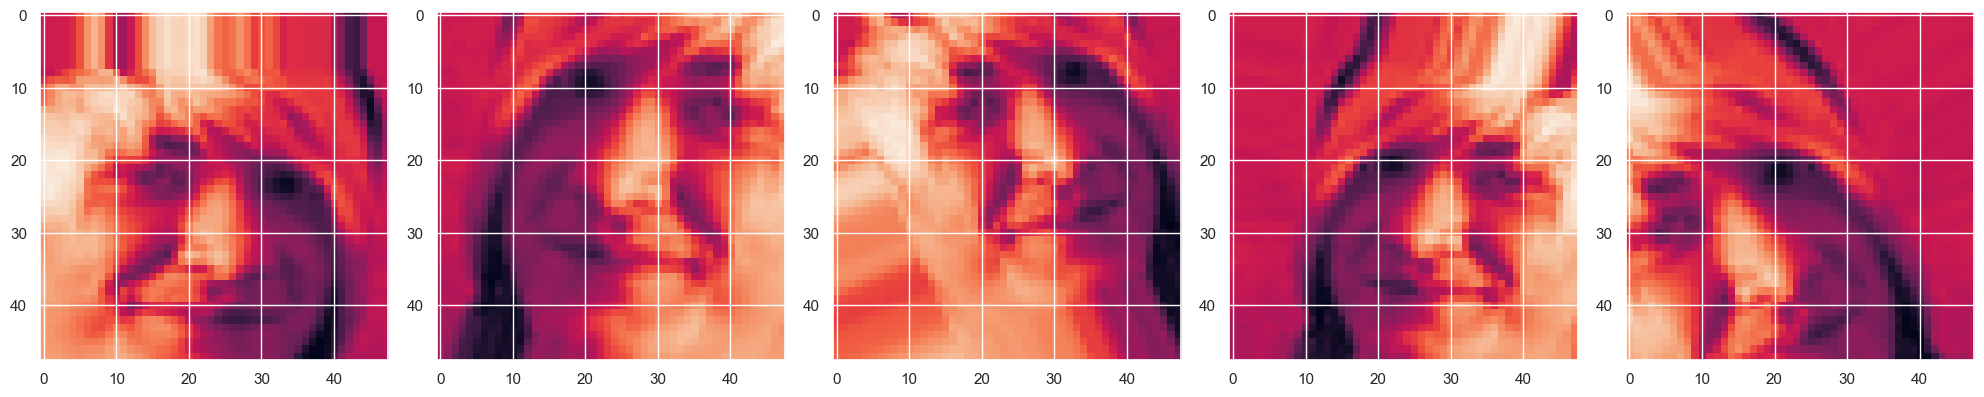

In [21]:
augmented_test_img = [test_generator[0][0][0] for i in range(5)]
PlotImage(augmented_test_img)

MODEL

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = (IMG_SHAPE, IMG_SHAPE, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    # tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    # tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    # tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation = 'softmax')
])

c:\Users\Arnav\Desktop\ipynb\CNN\Emotion_Detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

Checkpoints and vaious Hyperparameters

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

In [26]:
# Checkpoint and various Hyperparametes

file_path = "Model/M1"
name = "Emotion_Detection.keras"
checkpoint_path = os.path.join(file_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1, mode='min', monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, verbose=1, min_delta=0.001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(file_path, 'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

Training Model

In [27]:
train_steps_per_epochs = train_generator.samples // train_generator.batch_size + 1
val_steps_per_epochs = val_generator.samples // val_generator.batch_size + 1
test_steps_per_epochs = test_generator.samples // test_generator.batch_size + 1

In [28]:
try:
    history = model.fit(train_generator,
                        steps_per_epoch = train_steps_per_epochs,
                        epochs = EPOCHS,
                        validation_data = val_generator,
                        verbose = 1,
                        validation_steps = val_steps_per_epochs,
                        callbacks = callbacks)
except Exception as e:
    print(f'Exception raised : {e}')

Epoch 1/100


c:\Users\Arnav\Desktop\ipynb\CNN\Emotion_Detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.2100 - loss: 2.3710
Epoch 1: val_loss improved from inf to 2.24924, saving model to Model\Emotion_Detection.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 219s 946ms/step - accuracy: 0.2101 - loss: 2.3695 - val_accuracy: 0.1712 - val_loss: 2.2492 - learning_rate: 0.0010
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100


C:\Users\Arnav\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
c:\Users\Arnav\Desktop\ipynb\CNN\Emotion_Detection\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\Arnav\Desktop\ipynb\CNN\Emotion_Detection\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\Arnav\Desktop\ipynb\CNN\Emotion_Detection\.venv\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Lea

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.2576 - loss: 1.7910
Epoch 3: val_loss did not improve from 2.24924
230/230 ━━━━━━━━━━━━━━━━━━━━ 213s 928ms/step - accuracy: 0.2576 - loss: 1.7910 - val_accuracy: 0.1860 - val_loss: 2.6201 - learning_rate: 0.0010
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.2542 - loss: 1.7845
Epoch 5: val_loss improved from 2.24924 to 1.83302, saving model to Model\Emotion_Detection.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 214s 928ms/step - accuracy: 0.2542 - loss: 1.7845 - val_accuracy: 0.2585 - val_loss: 1.8330 - learning_rate: 0.0010
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.2625 - loss: 1.7751
Epoch 7: val_loss improved from 1.83302 to 1.81434, saving model to Mo

In [47]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

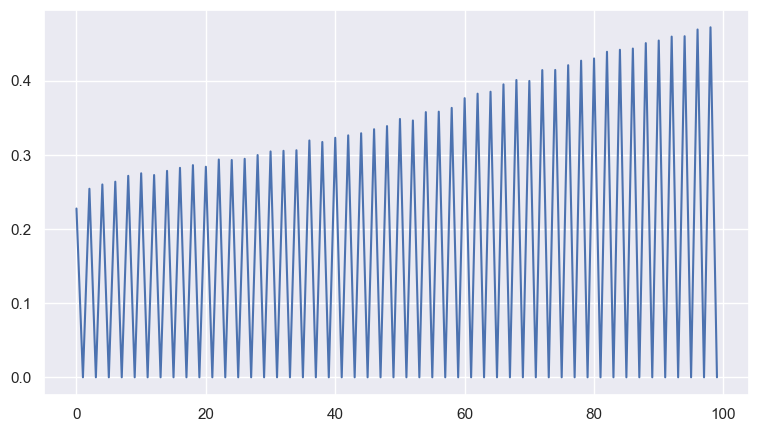

In [30]:
plot_training_history(history)

In [37]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

230/230 ━━━━━━━━━━━━━━━━━━━━ 58s 251ms/step - accuracy: 0.4949 - loss: 1.3184


c:\Users\Arnav\Desktop\ipynb\CNN\Emotion_Detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 609ms/step - accuracy: 0.4812 - loss: 1.3605
final train accuracy = 49.71 , validation accuracy = 48.01


In [38]:
steps = test_generator.samples // test_generator.batch_size + 1
predict = model.predict(test_generator, steps = steps)

72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step


In [39]:
predict

array([[0.1913173 , 0.01063323, 0.19869839, ..., 0.33805382, 0.19211897,
        0.04424721],
       [0.06431869, 0.01106895, 0.25529975, ..., 0.1701576 , 0.11662545,
        0.3459467 ],
       [0.00267207, 0.00127393, 0.00339025, ..., 0.00390528, 0.00129499,
        0.00122021],
       ...,
       [0.09934288, 0.02216944, 0.28832072, ..., 0.20361385, 0.3075349 ,
        0.03922209],
       [0.04492872, 0.01078024, 0.10135094, ..., 0.21275371, 0.16594747,
        0.01036145],
       [0.07003398, 0.00377166, 0.15391251, ..., 0.2174923 , 0.04713123,
        0.50230867]], dtype=float32)

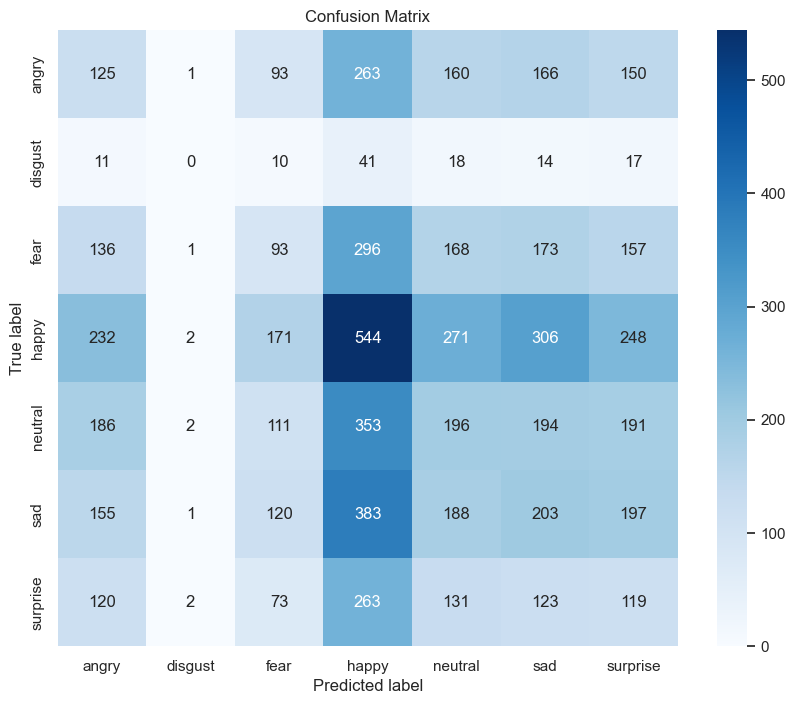

In [40]:
predicted = np.argmax(predict, axis = 1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.09      0.11      1024
       happy       0.25      0.31      0.28      1774
     neutral       0.17      0.16      0.17      1233
         sad       0.17      0.16      0.17      1247
    surprise       0.11      0.14      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



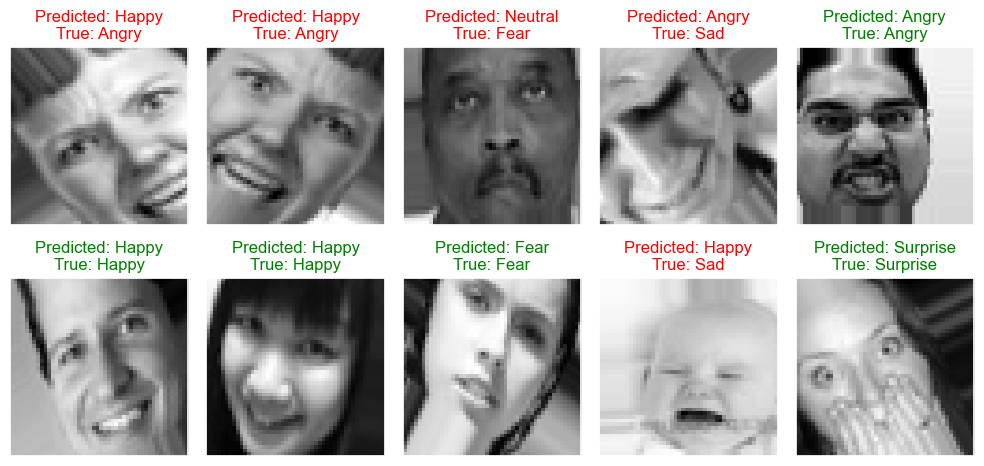

In [42]:
# Making Predictions:

Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
batch_size = test_generator.batch_size
Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 5), subplot_kw = {'xticks' : [], 'yticks' : []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis = 0)
    
    # Making a prediction
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis = 0), verbose = 0), axis = 1)[0]
    
    # Displaying
    ax.imshow(Random_Img.squeeze(), cmap = 'gray')
    color = 'green' if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else 'red'
    ax.set_title(f'Predicted: {Emotion_Classes[Model_Prediction]}\nTrue: {Emotion_Classes[Random_Img_Label]}', color = color)
    
plt.tight_layout()

## Model VGG16

In [48]:
# train_dir, test_dir Train and Test Directiories

# Hyper Parameters
img_height, img_width = 224, 224
BATCH_SIZE = 64
EPOCHS = 100
NUM_CLASSES = 7

In [49]:
img_gen = ImageDataGenerator(
    rescale = 1 / 255.,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    dtype = 'float32'
)

test_gen = ImageDataGenerator(
    rescale = 1 / 255.,
    dtype = 'float32'
)

In [50]:
def convert_to_float32(generator):
    for images, labels in generator:
        yield images.astype('float32'), labels

In [51]:
train_generator = img_gen.flow_from_directory(directory = train_dir, target_size = (img_width, img_height), batch_size = BATCH_SIZE, class_mode = 'categorical', color_mode = 'rgb', subset = 'training', shuffle = True)

Found 28708 images belonging to 7 classes.


In [52]:
test_generator = test_gen.flow_from_directory(directory = test_dir, target_size = (img_width, img_height), batch_size = BATCH_SIZE, class_mode = 'categorical', color_mode = 'rgb')

Found 7178 images belonging to 7 classes.


In [53]:
train_generator.dtype

'float32'

In [54]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculating class weights to handle imbalances in the training data
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(classes),
    y = classes
)

# Converting from float64 to float32
class_weights = class_weights.astype('float32')

# Creating a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights : ", class_weights_dict)

Class Weights :  {0: np.float32(1.0265689), 1: np.float32(9.406291), 2: np.float32(1.0012556), 3: np.float32(0.568419), 4: np.float32(0.82601064), 5: np.float32(0.8490979), 6: np.float32(1.2933279)}


In [55]:
test_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [56]:
classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [57]:
# classes = 7

# Clearing previous tensoflow sessions
tf.keras.backend.clear_session()

# Load the VGG16 base model
vgg = VGG16(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)     # Not including the top part of Model
# vgg = VGG16(input_shape = (224, 224, 3), weights = 'imagenet')      # Including top part 

vgg.summary()

I0000 00:00:1736407679.473009   84191 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3624 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Making the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [59]:
classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [60]:
# Flattening the Layer
x = tf.keras.layers.Flatten()(vgg.output)

# Adding Dense Relu activation layer
x = tf.keras.layers.Dense(1024, activation = 'relu', kernel_initializer = 'he_normal')(x)
x = tf.keras.layers.Dropout(.5)(x)

x = tf.keras.layers.Dense(512, activation = 'relu', kernel_initializer = 'he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(7, activation = 'softmax', kernel_initializer = 'he_normal')(x)

# Creating Model
model = tf.keras.Model(inputs = vgg.input, outputs = output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,59

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [61]:
# Checkpoint for Model 

file_path = "Model/M2"
name = "Emotion_Detection_VGG.keras"
checkpoint_path = os.path.join(file_path, name)

# Callbacks to save the model
checkpoint = ModelCheckpoint(filepath = checkpoint_path, save_best_only = True, verbose = 1, mode = 'min', monitor = 'val_loss')

# # Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1, min_delta = 0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(file_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]      # Can be adjusted accordingly


In [62]:
train_steps_per_epochs = train_generator.samples // train_generator.batch_size + 1
test_steps_per_epochs = test_generator.samples // test_generator.batch_size + 1

In [63]:
try:
    history = model.fit(
        train_generator,
        steps_per_epoch = train_steps_per_epochs,
        epochs = EPOCHS,
        validation_data = test_generator,
        validation_steps = test_steps_per_epochs,
        class_weight = class_weights_dict,
        callbacks = callbacks
    )
except Exception as e:
    print(f'Error Occured {e}')

/home/arnav/CNN/Emotion_Detection/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1736407731.115601   86457 service.cc:148] XLA service 0x7f672c0244e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736407731.144876   86457 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-01-09 07:28:51.182737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736407731.450614   86457 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-09 07:28:52.656073: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-09 07:28:52.656139: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out

232/449 ━━━━━━━━━━━━━━━━━━━━ 1:06 308ms/step - accuracy: 0.2068 - loss: 1.9601

2025-01-09 07:30:30.787278: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.2447 - loss: 1.8834

2025-01-09 07:31:55.575451: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208', 220 bytes spill stores, 220 bytes spill loads

2025-01-09 07:31:55.869703: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208_0', 228 bytes spill stores, 228 bytes spill loads

2025-01-09 07:31:56.090902: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208_0', 428 bytes spill stores, 524 bytes spill loads

2025-01-09 07:32:27.112712: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208', 220 bytes spill stores, 220 bytes spill loads

2025-01-09 07:32:27.309531: I external/local_xla/xla


Epoch 1: val_loss improved from inf to 1.48586, saving model to Model/M2/Emotion_Detection_VGG.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 223s 437ms/step - accuracy: 0.2449 - loss: 1.8831 - val_accuracy: 0.4198 - val_loss: 1.4859 - learning_rate: 1.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4054 - loss: 1.5539
Epoch 2: val_loss improved from 1.48586 to 1.31137, saving model to Model/M2/Emotion_Detection_VGG.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 171s 381ms/step - accuracy: 0.4054 - loss: 1.5538 - val_accuracy: 0.4968 - val_loss: 1.3114 - learning_rate: 1.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4551 - loss: 1.4277
Epoch 3: val_loss did not improve from 1.31137
449/449 ━━━━━━━━━━━━━━━━━━━━ 170s 378ms/step - accuracy: 0.4551 - loss: 1.4277 - val_accuracy: 0.4855 - val_loss: 1.3346 - learning_rate: 1.0000e-04
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4872 - loss: 1.3385
Epoch 4: val_loss improved from 

In [66]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print('Train Accuracy: {:.2f}\nTest Accuracy: {:.2f}'.format(train_accu*100, test_accu*100))

448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6412 - loss: 0.9440

2025-01-09 16:04:46.070033: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208', 4 bytes spill stores, 4 bytes spill loads

2025-01-09 16:04:46.098311: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208', 236 bytes spill stores, 236 bytes spill loads

2025-01-09 16:04:46.416335: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208_0', 1204 bytes spill stores, 1436 bytes spill loads

2025-01-09 16:04:46.542750: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208', 4 bytes spill stores, 4 bytes spill loads

2025-01-09 16:04:46.626786: I external/local_xla/xla/stream_

449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 302ms/step - accuracy: 0.6412 - loss: 0.9440
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - accuracy: 0.5839 - loss: 1.0974
Train Accuracy: 63.79
Test Accuracy: 58.93


In [70]:
np.ceil(test_generator.samples / test_generator.batch_size)

np.float64(113.0)

In [71]:
predict = model.predict(test_generator, steps = 113)
predict

113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 268ms/step


array([[1.9797108e-03, 6.9883034e-05, 2.4101082e-02, ..., 9.3225116e-04,
        8.0891553e-04, 9.7187561e-01],
       [4.3590999e-01, 8.2767551e-04, 5.2951992e-01, ..., 1.1622350e-03,
        1.9409070e-02, 1.0723336e-02],
       [2.0850970e-01, 6.0981526e-03, 2.6854303e-01, ..., 2.2524719e-01,
        2.4471878e-01, 3.1585217e-02],
       ...,
       [4.7072742e-02, 2.9112762e-03, 7.4922197e-02, ..., 6.4453530e-01,
        1.7522891e-01, 5.7951086e-03],
       [1.3464264e-04, 1.8520558e-07, 1.7735224e-02, ..., 1.7865725e-05,
        1.5375166e-05, 9.8167086e-01],
       [1.2672381e-01, 2.8213721e-02, 2.4263109e-01, ..., 1.4521851e-01,
        3.8450697e-01, 6.8166964e-03]], dtype=float32)

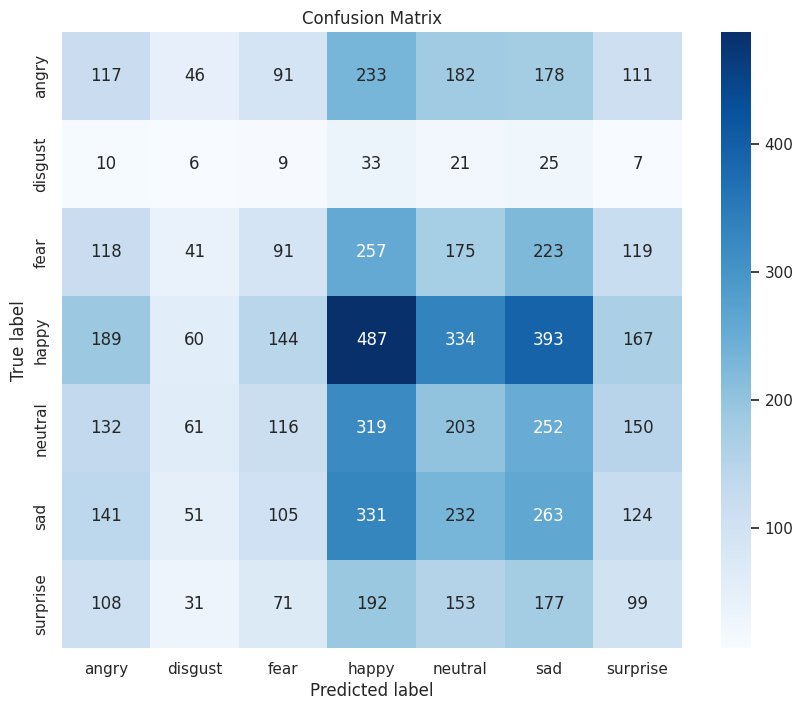

In [72]:
true_classes = test_generator.classes
predicted = np.argmax(predict, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [73]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted,
                               target_names = class_labels,
                               zero_division = 0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.12      0.13       958
     disgust       0.02      0.05      0.03       111
        fear       0.15      0.09      0.11      1024
       happy       0.26      0.27      0.27      1774
     neutral       0.16      0.16      0.16      1233
         sad       0.17      0.21      0.19      1247
    surprise       0.13      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178



## Model ResNet50

In [74]:
# train_dir, test_dir Train and Test Directiories

# Hyper Parameters
BATCH_SIZE = 64
# EPOCHS = 100
NUM_CLASSES = 7

In [75]:
train_gen = ImageDataGenerator(
    rescale = 1 / 255.,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    zoom_range = 0.2
)

test_gen = ImageDataGenerator(
    rescale = 1 / 255.
)

In [76]:
train_generator = train_gen.flow_from_directory(
    directory = train_dir,
    batch_size = BATCH_SIZE,
    target_size = (224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    subset = 'training'
)

test_generator = test_gen.flow_from_directory(
    directory = test_dir,
    batch_size = BATCH_SIZE,
    target_size = (224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False
)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [77]:
# Extracting class labels of all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculating class weights to handle imbalances in the training data
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(classes),
    y = classes
)

# Converting from float64 to float32
# class_weights = class_weights.astype('float32')

# Creating a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))
print(f'Class Weights : {class_weights_dict}')

Class Weights : {0: np.float64(1.0265689254425174), 1: np.float64(9.406290956749672), 2: np.float64(1.0012555803571428), 3: np.float64(0.5684189684189684), 4: np.float64(0.826010645950223), 5: np.float64(0.8490979000295771), 6: np.float64(1.293327927197369)}


In [78]:
# ResNet50V2 Model

rsnt50 = ResNet50V2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')     # without including top layers of model 
# rsnt50 = ResNet50V2(input_shape = (224, 224, 3), weights = 'imagenet')     # including top layers of model

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [79]:
# Frezzing all layers except last 50

rsnt50.trainable = True

for layer in rsnt50.layers[:-50]:
    layer.trainable = False

In [80]:
# Creating Model

def Create_Rsnt50():
    model = tf.keras.models.Sequential([
        rsnt50,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(7, activation = 'softmax')
    ])
    
    return model

In [81]:
model = Create_Rsnt50()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [82]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [83]:
# Checkpoint for Model 

file_path = "Model/M3"
name = "Emotion_Detection_RESNET50.keras"
checkpoint_path = os.path.join(file_path, name)

# Callbacks to save the model
checkpoint = ModelCheckpoint(filepath = checkpoint_path, 
                             save_best_only = True, 
                             verbose = 1, 
                             mode = 'min', 
                             monitor = 'val_loss')

# # Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy', 
                           patience = 7, 
                           verbose = 1, 
                           restore_best_weights = True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2, 
                              patience = 2, 
                              verbose = 1, 
                              min_delta = 0.0005)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(file_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]      # Can be adjusted accordingly

In [84]:
train_steps_per_epochs = train_generator.samples // train_generator.batch_size + 1
test_steps_per_epochs = test_generator.samples // test_generator.batch_size + 1

In [85]:
try:
    history = model.fit(
        train_generator,
        steps_per_epoch = train_steps_per_epochs,
        epochs = 50,
        validation_data = test_generator,
        validation_steps = test_steps_per_epochs,
        class_weight = class_weights_dict,
        callbacks = callbacks
    )
except Exception as e:
    print(f'Error Occured : {e} ')

/home/arnav/CNN/Emotion_Detection/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
237/449 ━━━━━━━━━━━━━━━━━━━━ 1:03 302ms/step - accuracy: 0.3377 - loss: 1.8597

2025-01-09 17:42:24.836730: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=15,k6=0,k13=1,k14=0,k22=0} for conv (f32[36,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,256,28,28]{3,2,1,0}, f32[512,256,1,1]{3,2,1,0}, f32[512]{0}, f32[36,512,28,28]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-09 17:42:24.843168: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.446494539s
Trying algorithm eng33{k2=15,k6=0,k13=1,k14=0,k22=0} for conv (f32[36,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,256,28,28]{3,2,1,0}, f32[512,256,1,1]{3,2,1,0}, f32[512]{0}, f32[36,512,28,28]{3,2,1,0}), window={size=1x1}, dim

449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3790 - loss: 1.7379
Epoch 1: val_loss improved from inf to 19.71571, saving model to Model/M3/Emotion_Detection_RESNET50.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 215s 407ms/step - accuracy: 0.3791 - loss: 1.7375 - val_accuracy: 0.3183 - val_loss: 19.7157 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5136 - loss: 1.3380
Epoch 2: val_loss improved from 19.71571 to 1.29893, saving model to Model/M3/Emotion_Detection_RESNET50.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 152s 336ms/step - accuracy: 0.5137 - loss: 1.3379 - val_accuracy: 0.5286 - val_loss: 1.2989 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5595 - loss: 1.1737
Epoch 3: val_loss improved from 1.29893 to 1.21283, saving model to Model/M3/Emotion_Detection_RESNET50.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 149s 332ms/step - accuracy: 0.5595 - loss: 1.1737 - val_accuracy: 0.5578 - val_loss: 1.2128 - learn

In [86]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print('Train Accuracy: {:.2f}\nTest Accuracy: {:.2f}'.format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 284ms/step - accuracy: 0.7342 - loss: 0.7287
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.6493 - loss: 0.9701
Train Accuracy: 72.99
Test Accuracy: 67.30


In [87]:
predict = model.predict(test_generator, steps = 113)

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step


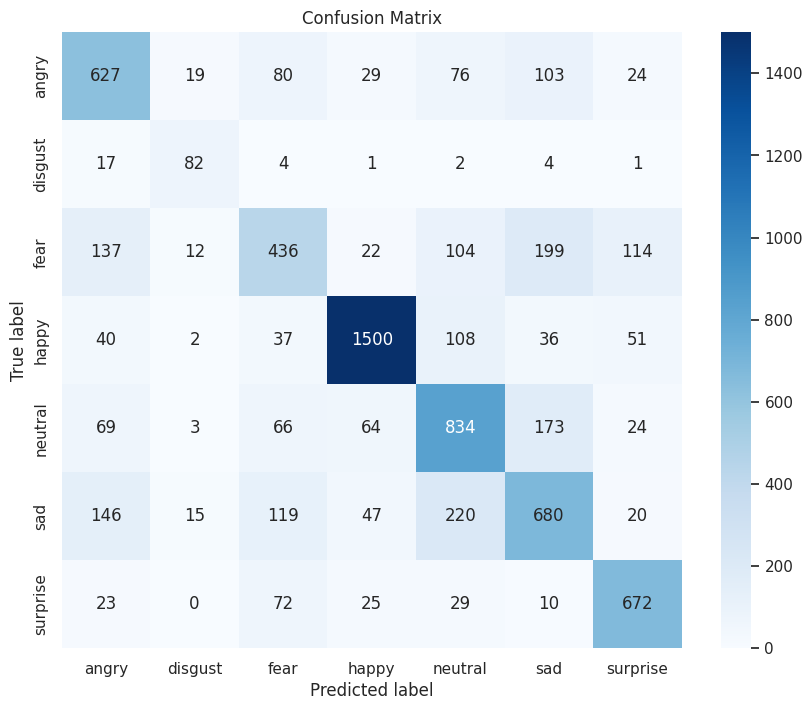

In [88]:
true_classes = test_generator.classes
predicted = np.argmax(predict, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [89]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted,
                               target_names = class_labels,
                               zero_division = 0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.59      0.65      0.62       958
     disgust       0.62      0.74      0.67       111
        fear       0.54      0.43      0.47      1024
       happy       0.89      0.85      0.87      1774
     neutral       0.61      0.68      0.64      1233
         sad       0.56      0.55      0.55      1247
    surprise       0.74      0.81      0.77       831

    accuracy                           0.67      7178
   macro avg       0.65      0.67      0.66      7178
weighted avg       0.67      0.67      0.67      7178



In [90]:
model.save("Model/M3/Resnet.keras")